In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.coordinates import AltAz, EarthLocation, SkyCoord
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import get_sun
from astropy.coordinates import get_body
from astropy.visualization import astropy_mpl_style, quantity_support

In [2]:
# observatory location (Ondrejov and La Silla)
ondrejov = EarthLocation(lat=49.915175*u.deg, lon=14.780994*u.deg, height=500*u.m)
lasilla = EarthLocation(lat=-29.261165622*u.deg, lon=-70.731330408*u.deg, height=2400*u.m)

ondrejov_utcoffset = +2*u.hour  # Central Europian Time # 31.3 switching to +2 (summer time)
lasilla_utcoffset = -4*u.hour # 2.4 switching to -4 (summer time)

### **ENTER DATE AND LOCATION**
### **-----------**

In [3]:
date = '2024-5-1 00:00:00'
date_short = '2024-5-1'
# in format 'yyyy-mm-dd 00:00:00' as midnight of the night you want to observe (in UTC)

obs_location = ondrejov
# enter: ondrejov or lasilla

folder = '2024_04_27-30'
# folder where the files will be input

### **-----------**

It is irrelevant, if I substract the utcoffset for midnight or delta_midnight, it doesn't change frame_night. It does however change delta_midnight jd and subsequent jd calculations from midnight

In [4]:
# time offset
if obs_location == ondrejov:
    offset = ondrejov_utcoffset
    loc_name = "Ondrejov"
elif obs_location == lasilla:
    offset = lasilla_utcoffset
    loc_name = "La Silla"
else:
    print('Location not found')

# time axis
midnight = Time(date) # in utc
delta_midnight = np.linspace(-12, 12, 1000)*u.hour # in utc
frame_night = AltAz(obstime = midnight + delta_midnight, location = obs_location)
# time jd
delta_midnight_jd = np.linspace(0, 1, 1000)*u.d
time = np.array((midnight -0.5*u.d).jd) + np.array(delta_midnight_jd)
date_jd_start = float((midnight - 0.5*u.d).jd)
date_jd_end = float((midnight + 0.5*u.d).jd)
# sun
sun_altaz = get_sun(midnight+delta_midnight).transform_to(frame_night)
sun = sun_altaz.alt < 0
sunset_i = np.where(sun == 1)[0][0]
sunrise_i = np.where(sun == 1)[0][-1]
# sunrise and sunset values
sunrise = delta_midnight[sunrise_i].value
sunset = delta_midnight[sunset_i].value
print(sunset, sunrise)

-5.777777777777778 3.6876876876876867


In [5]:
# object csv file
# Structure: ID, ra, dec, f_gdor, m0
data = pd.read_csv('{}/stars.csv'.format(folder))
n = len(data['ID'])

In [6]:
# csv file with observation information = how many times were certain objects observed
obs_time = pd.read_csv('{}/obs_times.csv'.format(folder))

In [7]:
# Plot characteristics
plt.style.use(astropy_mpl_style)
quantity_support()

import matplotlib.colors
#cmap_orangeteal = matplotlib.colors.LinearSegmentedColormap.from_list("", ["orangered","orange","white","teal", "darkslategray"])
cmap_orangeteal = matplotlib.colors.LinearSegmentedColormap.from_list("", ["teal", "coral"])

C:\Users\admin\anaconda3\envs\astro\Lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
C:\Users\admin\anaconda3\envs\astro\Lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "taiutc" yielded 2 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


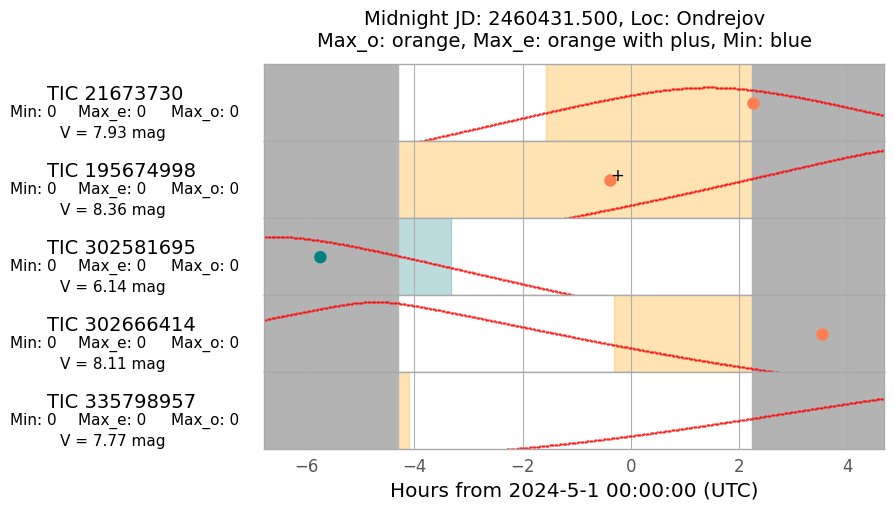

In [8]:
fig, ax = plt.subplots(n, 1, sharex=True, gridspec_kw={'hspace': 0})
fig.set_figheight(1 * n)
fig.set_figwidth(8)

fig.suptitle('Midnight JD: {:.3f}, Loc: {}\nMax_o: orange, Max_e: orange with plus, Min: blue'.format(midnight.jd, loc_name),
             fontsize=14, y=0.99) #0.93
#plt.subplots_adjust(top=0.90 + 0.10/n)

for j in range(n):
    # Object information
    object_ra = data['ra'][j]
    object_dec = data['dec'][j]
    object_name = 'TIC ' + str(data['ID'][j])
    object_mag = data['Vmag'][j]
    period = 1 / (data['f_gdor'][j])
    cond_d = period * 0.1 # one tenth of the period => 0.1 phase in d
    cond_h = period * 24 * 0.1 # one tenth of the period => 0.1 phase in h
    M0 = data['m0'][j]

    # Coordinates of object
    c_icrs = SkyCoord(ra = object_ra*u.degree, dec = object_dec*u.degree, frame='icrs')
    c_altaz = c_icrs.transform_to(frame_night)

    # Phase calculations
    a = M0
    
    while a <= date_jd_start:
        a = a + period
    if a > date_jd_start:
        a = a - period # a is the last minimum before the desired date
    
    points = np.zeros(666)
    i = 1
    b = a
    
    while b <= date_jd_end:
        points[i - 1] = b
        b = a + (period/2) * i # /2 gives me only phases 0 and 0.5
        i = i + 1
    
    # times in JD format for the selected night
    condition = points >= date_jd_start
    points_at_date = points[condition]
    points_at_date_s = points_at_date - cond_d
    points_at_date_e = points_at_date + cond_d
    # phase of the object at selected interesting points
    phases_at_points = np.zeros(len(points_at_date))
    for i in range(len(points_at_date)):
        phases_at_points[i] = round(((points_at_date[i] - M0)/period), 3) - int(round(((points_at_date[i] - M0)/period), 3))
    # time in delta_midnight format for interesting points (delta_midnight is from utc time)
    time_at_date = np.array((Time(points_at_date*u.d, format='jd') - midnight.jd).jd) * 24
    # start and end of the phases from 0.9 to 0.1 and 0.4 to 0.6
    time_at_date_s = time_at_date - cond_h
    time_at_date_e = time_at_date + cond_h

    # TABLE
    timedelta_values = [pd.to_timedelta(str(hour) + ' hours') for hour in time_at_date]
    hours_values = [str(timedelta).split(' ')[-1].lstrip('+') for timedelta in timedelta_values]
    timedelta_values_s = [pd.to_timedelta(str(hour) + ' hours') for hour in time_at_date_s]
    hours_values_s = [str(timedelta).split(' ')[-1].lstrip('+') for timedelta in timedelta_values_s]
    timedelta_values_e = [pd.to_timedelta(str(hour) + ' hours') for hour in time_at_date_e]
    hours_values_e = [str(timedelta).split(' ')[-1].lstrip('+') for timedelta in timedelta_values_e]
    
    table = pd.DataFrame(
        {
        'phase': phases_at_points,
        'middle_jd': points_at_date,
        'middle_h_utc': hours_values,
        'middle_h': time_at_date,
        'start_jd': points_at_date_s,
        'start_h_utc': hours_values_s,
        'end_jd': points_at_date_e,
        'end_h_utc': hours_values_e,
        }
    )
    table.to_csv('{}/Tables/{}_{}.csv'.format(folder, data['ID'][j], date_short), index = False)
    
    # PLOT
    y = np.full(len(time_at_date), 0.66)
    
    ax1 = ax[j]
    ax1.scatter(delta_midnight, c_altaz.alt / 90, s = 0.2, color = 'red', label = object_name)
    # -0.3 gives me alt above 30 degrees above horizon
    scatter = ax1.scatter(time_at_date, y,c=phases_at_points, lw=0, s=80,
            cmap=cmap_orangeteal, vmin = 0, vmax = 0.5)
    
    # adding + to the even maxima, making min = 0, maxe = 2, maxo =1 labels for each phase
    labels_phase = np.zeros(len(points_at_date))
    for k in range(len(points_at_date)):
        even_max = round((points_at_date[k] - M0) / period, 1)
        if even_max - int(even_max) != 0:
            epoch = even_max - 0.5
            if epoch % 2 == 0 and time_at_date[k] <= (sunrise + 1) and time_at_date[k] >= (sunset - 1):
                ax1.text(time_at_date[k], 0.66, '+', color = 'black')
                labels_phase[k] = 2
            else:
                labels_phase[k] = 1
        else:
            labels_phase[k] = 0
            
    # adding info about how many times were certain characteristics observed
    if obs_time['ID'][j] != data['ID'][j]:
        print('ABORT! ABORT! ABANDON SHIP!')

    ax1.text(-0.41, 0.33, 'Min: {:.0f}'.format(np.nan_to_num(obs_time['min'][j], nan=0)), fontsize=11, transform = ax1.transAxes)
    ax1.text(-0.3, 0.33, 'Max_e: {:.0f}'.format(np.nan_to_num(obs_time['max_e'][j], nan=0)), fontsize=11, transform = ax1.transAxes)
    ax1.text(-0.15, 0.33, 'Max_o: {:.0f}'.format(np.nan_to_num(obs_time['max_o'][j], nan=0)), fontsize=11, transform = ax1.transAxes)

    # filling out phases 0.9-0.1 and 0.4-0.6
    obs_min = np.nan_to_num(obs_time['min'][j], nan=0)
    obs_me = np.nan_to_num(obs_time['max_e'][j], nan=0)
    obs_mo = np.nan_to_num(obs_time['max_o'][j], nan=0)
    for l in range(len(time_at_date)):
        if phases_at_points[l] == 0.5:
            if labels_phase[l] == 2 and obs_me != 0:
                fill_color = 'lightgray'
            elif labels_phase[l] == 1 and obs_mo != 0:
                fill_color = 'lightgray'
            else:
                fill_color = 'orange'
        elif phases_at_points[l] == 0 and obs_min != 0:
            fill_color = 'lightgray'
        else:
            fill_color = '#23898e'
        ax1.fill_between(delta_midnight, -90*u.deg, 90*u.deg,
                 where=((time_at_date[l] - cond_h)*u.h <= delta_midnight) & (delta_midnight <= (time_at_date[l] + cond_h)*u.h),
                color=fill_color, alpha=0.3, zorder=0)

    ax1.fill_between(delta_midnight, -90*u.deg, 90*u.deg,
                 sun_altaz.alt > -12*u.deg, color='0.7', zorder=0)
    
    ax1.set_yticks([])
    ax1.tick_params(color='black')
    
    ax1.text(-0.35, 0.55, object_name, fontsize=14, transform = ax1.transAxes)
    ax1.text(-0.33, 0.05, 'V = {:.2f} mag'.format(object_mag), fontsize=11, transform = ax1.transAxes)
    
    ax1.set_xlim((sunset - 1)*u.h, (sunrise + 1)*u.h)
    ax1.set_ylim(0.33, 1)

    ax1.set_ylabel('')
    ax1.grid(which = 'major', axis = 'y')

#ax1.set_xlabel('Hours from {} (UTC),\nLocal midnight: {} (UTC)'.format(date, midnight - offset))
ax1.set_xlabel('Hours from {} (UTC)'.format(date))
fig.savefig('{}/{}.png'.format(folder, date_short), format = 'png', bbox_inches = 'tight')
#cbar = fig.colorbar(scatter, ax=ax)
#cbar.set_label('Phase')
#cbar.ax.set_position([ax1.get_position().x1 + 0.02,  # X position (right of the plot)
#                      ax1.get_position().y0,          # Y position (bottom of the plot)
#                      0.025,                            # Width of the colorbar
#                      ax1.get_position().height * n])

In [9]:
data

,ID,ra,dec,Vmag,f_gdor,m0
0,21673730,255.721906,31.690197,7.93000,0.62470,2.459728e+06
1,195674998,310.404451,43.836751,8.36000,0.50408,2.459827e+06
2,302581695,133.482012,35.538295,6.14400,0.98712,2.458875e+06
3,302666414,163.004997,55.355145,8.11000,0.62195,2.459616e+06
4,335798957,333.054291,63.738700,7.76749,0.76552,2.459887e+06
